In [50]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pickle
from sklearn.model_selection import train_test_split
import os
import shutil
import random
import time

In [51]:
def load_data(path: str):
    """
    This function loads data from a pickle file located at the provided path.

    Parameters:
        path (str): The path to the pickle file.

    Returns:
        par_comb (np.ndarray): The parameter combinations.
        S11_par (np.ndarray): The best parametric data.
        frequency (np.ndarray): The frequency data.
        degrees (np.ndarray): The degrees data.
        combined_gain (np.ndarray): The combined gain list.
        std_dev (np.ndarray): The standard deviation of Phi.
        efficiency (np.ndarray): The efficiency data.
    """

    with open(path,'rb') as file:
        data_dict = pickle.load(file)
    print(f"Dictionary keys: {data_dict.keys()}")

    par_comb = np.asarray(data_dict['Parameter combination'])
    S11_vals = np.asarray(data_dict['S1,1'])
    frequency = np.asarray(data_dict['Frequency'])
    S11_parametrized = np.asarray(data_dict['Parametric S1,1'])
    degrees = np.asarray(data_dict['degrees'])
    combined_gain = np.asarray(data_dict['combined gain list'])
    std_dev = np.asarray(data_dict['Standard deviation Phi'])
    efficiency = np.asarray(data_dict['efficiency'])
    #efficiency = np.asarray(list(data_dict['efficiency'].values()))
    return par_comb, S11_vals, S11_parametrized, frequency, degrees, combined_gain, std_dev, efficiency

def normalize_data(data, inverse: bool):
    if inverse:
        data_norm = data*np.std(data) + np.mean(data)
    else:   
        mean = np.mean(data)
        std = np.std(data)
        data_norm = (data-mean)/std
    return data_norm


In [52]:
path = 'C:/Users/nlyho/Desktop/MachineLearning/'
par_comb, S11_vals, S11_parameterized, frequency, degrees, combined_gain, std_dev, efficiency = load_data(f"{path}data/simple_wire2_final_with_parametric.pkl")

# Normalize data
# S11_vals = normalize_data(S11_vals, False)
# S11_parameterized = normalize_data(S11_parameterized, False)
# frequency = normalize_data(frequency, False)
# degrees = normalize_data(degrees, False)
# combined_gain = normalize_data(combined_gain, False)
# std_dev = normalize_data(std_dev, False)
# efficiency = normalize_data(efficiency, False)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(par_comb, S11_vals, test_size=0.3, shuffle=True, random_state=42)


# Find test curves where the S11 goes below -10 dB and the frequency is below 2 GHz
test_indices = []
for idx, i in enumerate(y_test):
    if np.min(i) < -10 and frequency[np.argmin(i)] < 2000:
        test_indices.append(idx)
print(f"Number of test curves that satisfy the condition: {len(test_indices)}")
random_indices = random.sample(test_indices, 10)

# # plot random test data curves to verify that a good solution is within the test set
# plt.figure(figsize=(50, 50))
# for idx, i in enumerate(random_indices):
#     plt.subplot(5, 2, idx+1)
#     plt.plot(frequency, y_test[i][0:1001], label='test')
#     plt.legend()
#     plt.grid(True)
#     plt.ylim([-40,2])
# plt.show()

Dictionary keys: dict_keys(['Parameter combination', 'S1,1', 'Frequency', 'degrees', 'combined gain list', 'Standard deviation Phi', 'efficiency', 'Parametric S1,1'])
Number of test curves that satisfy the condition: 122


In [53]:
# Make a 4 layer neural network using relu activation functions
model = keras.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(y_train.shape[1], activation='linear'))

model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss=keras.losses.MeanAbsoluteError(),
            metrics=[keras.metrics.MeanSquaredError()]
        )
model.summary()


# Train the model
history = model.fit(X_train,
                    y_train,
                    epochs=1000,
                    batch_size=100,
                    shuffle=True,
                    verbose=1)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 128)               512       
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                                                 
 dense_20 (Dense)            (None, 128)               16512     
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dense_23 (Dense)            (None, 1001)             

Epoch 1/1000
18/18 [==============================] - 1s 6ms/step - loss: 1.8913 - mean_squared_error: 10.9703
Epoch 2/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.4883 - mean_squared_error: 7.6807
Epoch 3/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.4257 - mean_squared_error: 7.2157
Epoch 4/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.3642 - mean_squared_error: 6.6769
Epoch 5/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.3255 - mean_squared_error: 6.3917
Epoch 6/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.3193 - mean_squared_error: 6.3266
Epoch 7/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.3052 - mean_squared_error: 6.3354
Epoch 8/1000
18/18 [==============================] - 0s 5ms/step - loss: 1.2929 - mean_squared_error: 6.1651
Epoch 9/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.2824 - mean_squared_error: 6.1439
Epoch 10/

24/24 [==============================] - 0s 3ms/step - loss: 0.2185 - mean_squared_error: 0.6283
Test loss: 0.21847747266292572
Test mae: 0.6282779574394226
24/24 [==============================] - 0s 2ms/step


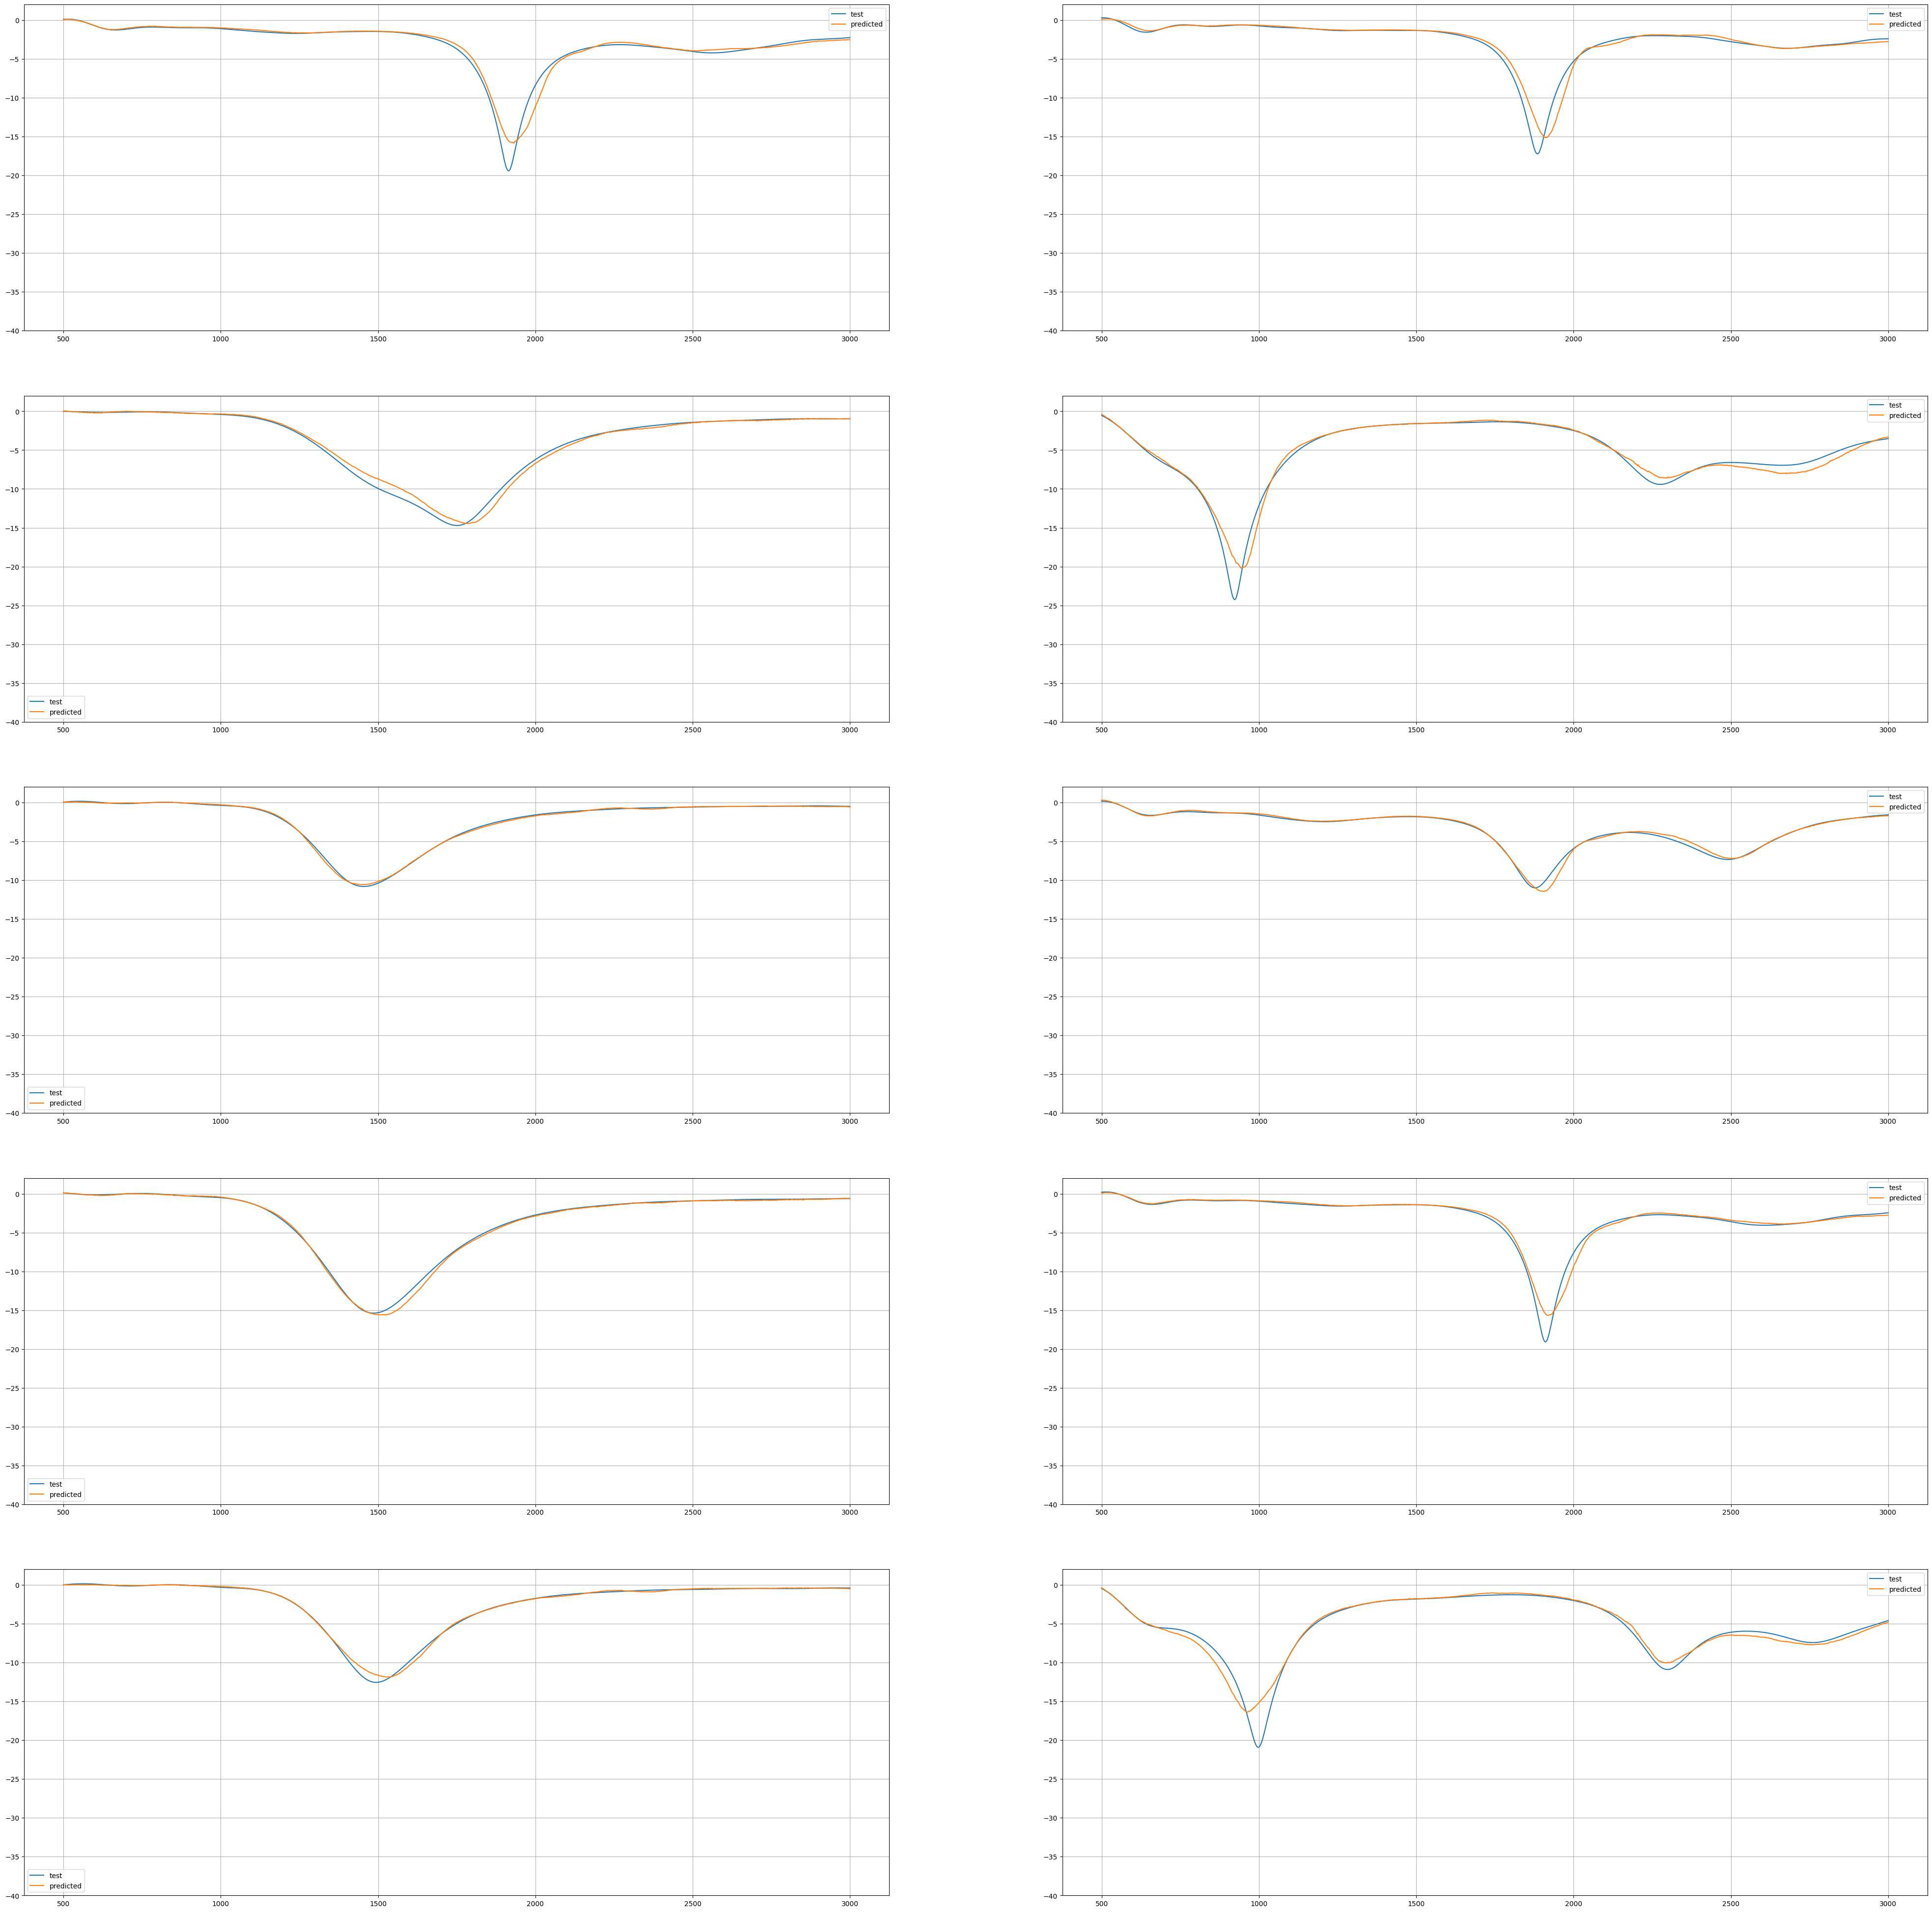

In [54]:
# # Plot the training and validation loss
# plt.figure(figsize=(10, 10))
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot the training and validation mae
# plt.figure(figsize=(10, 10))
# plt.plot(history.history['mae'], label='Training mae')
# plt.plot(history.history['val_mae'], label='Validation mae')
# plt.legend()
# plt.grid(True)
# plt.show()

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")
print(f"Test mae: {test_mae}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot the predicted S11 values
plt.figure(figsize=(50, 50))
for idx, i in enumerate(random_indices):
    plt.subplot(5, 2, idx+1)
    plt.plot(frequency, y_test[i][0:1001], label='test')
    plt.plot(frequency, y_pred[i][0:1001], label='predicted')
    plt.legend()
    plt.grid(True)
    plt.ylim([-40,2])
plt.show()
